# Experimental Semivariogram and Covariogram estimation

In this exercise you will learn how to build the **directional** experimental semivariance and covariance for your spatial data. You will use two basic functions:

- `calculate_semivariance()`
- `calculate_covariance()`

and their parameters defining direction of semivariogram.

## Prerequisites

- **Domain**:
  - understanding what are semivariance and covariance of spatial datasets
  - omnidirectional semivariance and omnidirectional covariance
- **Package**:
  - installation
- **Programming**:
  - Python basics

## Table of contents

1. Background.
2. Calculate experimental semivariance.
3. Plot experimental semivariogram.
4. Calculate experimental covariance.
5. Plot experimental covariogram.

In [5]:
import geopandas as gpd
from pyinterpolate import calculate_semivariance, calculate_covariance

import matplotlib.pyplot as plt

## Background

### Directional trends

Not every spatial process may be described by isotropic variograms. Sometimes we see a specific trend in one direction (N-S, W-E, or NE-SW, NW-SE). The interesting case is air pollution in Poland, the trend follows N-S axis, with higher PM 2.5 concentrations on the South and lower pollutant concentrations on the North, and similar values are grouped on the W-E axis.

In [7]:
VALUE_COL = 'PM2.5'
df = gpd.read_file('../data/air_pollution.gpkg', layer='pm2_5')
df.set_index('station_id', inplace=True)

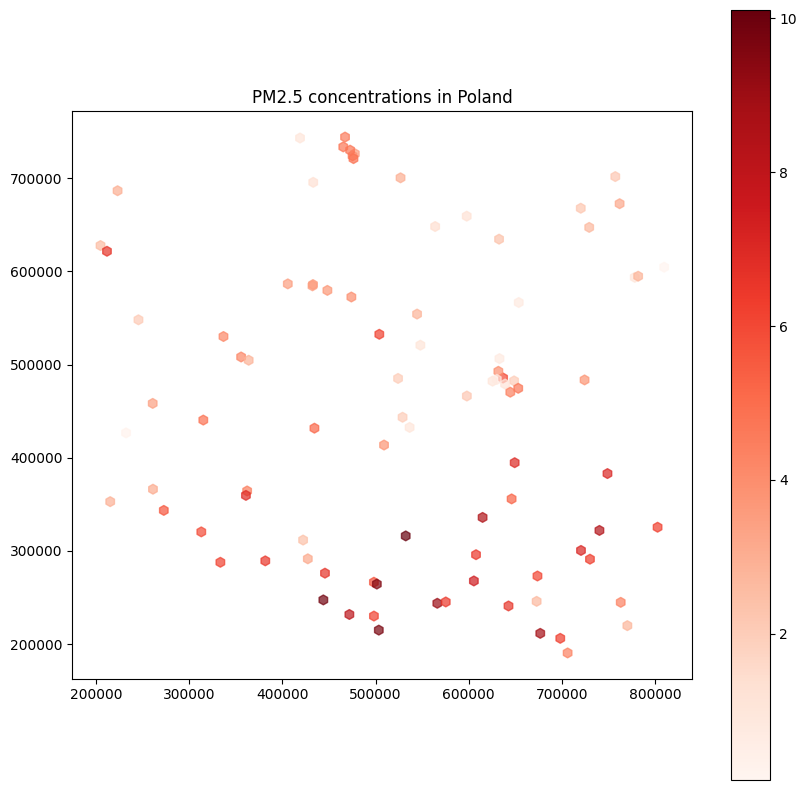

In [8]:
df.plot(figsize=(10, 10), column=VALUE_COL, legend=True, markersize=50, alpha=0.7, marker="h", cmap='Reds')
plt.title('PM2.5 concentrations in Poland')
plt.show()

### Including direction in experimental variogram

If we recall the previous chapter `Experimental Semivariogram and Covariogram`, there are three main parameters to set for the `calculate_semivariance()` and `calculate_covariance()` functions:

1. `ds`: `numpy array` with coordinates and observed values, for example: `[[0, 0, 10], [0, 1, 20]]`,
2. `step_size`: we must divide our analysis area into discrete **lags**. **Lags** are intervals (usually circular) within which we check if the point has a neighbor. For example, if we look into the lag `500`, then we are going to compare one point with other points in a distance `(0, 1000]` from this point,
3. `max_range`: This parameter represents the possible **maximum range of spatial dependency**. This parameter should be at most half of the extent.

But that's not everything! We didn't use three other parameters:

4. `direction`: it is a `float` in the range [0, 360]. We set the direction of the semivariogram:
  * 0 or 180: is WE direction,
  * 90 or 270 is NS direction,
  * 45 or 225 is NE-SW direction,
  * 135 or 315 is NW-SE direction.

5. `tolerance`: it is a `float` in the range [0, 1]. If we leave `tolerance` with default **1**, we will always get an isotropic semivariogram. Another edge case is if we set `tolerance` to **0**, then points must be placed on a single line with the beginning in the origin of the coordinate system and the angle given by the y-axis and direction parameter. If tolerance is > 0 and < 1, the bin is selected as an elliptical area with a major axis pointed in the same direction as the line for 0 tolerance.
  * The major axis size is `(tolerance * step_size)`,
  * The minor axis size is `((1 - tolerance) * step_size)`,
  * The baseline point is at the center of the ellipse.
  
Those parameters are used to estimate semivariance and covariance in a leading direction. The `direction` and `tolerance` parameters might be described with the picture:


<img src="images/dir_semi_tutorial_graphics.jpg" alt="The visualization of directional variogram calculation" style="max-width: 800px;"/>

* The top plane shows the black unit circle that represents the omnidirectional variogram. Within it, we see two ellipses: one is bright green and another is dark green.
* The bottom plane shows a unit circle and two ellipses: the brighter yellow, and darker purple.
* The long arrows within both circles are radii of the omnidirectional variogram or **the semi-major axis** of a directional ellipse. The `step_size` parameter controls its length. The shorter arrows are present only in the **directional variograms**. These represent the **semi-minor axes**. The `tolerance` parameter controls their length, and it is always:
 - a fraction of `step_size`,
 - **1**, in this case, a semivariogram is omnidirectional,
 - a value very close to 0 (but not 0) - then ellipse falls into line.
* The good idea is to set `tolerance` to 0.5 and gradually make it smaller or larger (depending on the spatial properties of a dataset).

### Directional variograms

First, let's define constants used for analysis.

In [9]:
SEMI_MAJOR_AXIS_SIZE = 60000  # meters
MAX_RANGE = 400000  # meters
TOLERANCE = 0.2
WE_DIRECTION = 0  # or 180
NS_DIRECTION = 90  # or 270
NW_SE_DIRECTION = 135  # or 315
NE_SW_DIRECTION = 45  # or 225

DIRECTIONS_ABBR = ['WE', 'NS', 'NW-SE', 'NE-SW']
DIRECTIONS = [WE_DIRECTION, NS_DIRECTION, NW_SE_DIRECTION, NE_SW_DIRECTION]

#### Directional semivariograms

In this step we are going to calculate directional semivariograms.

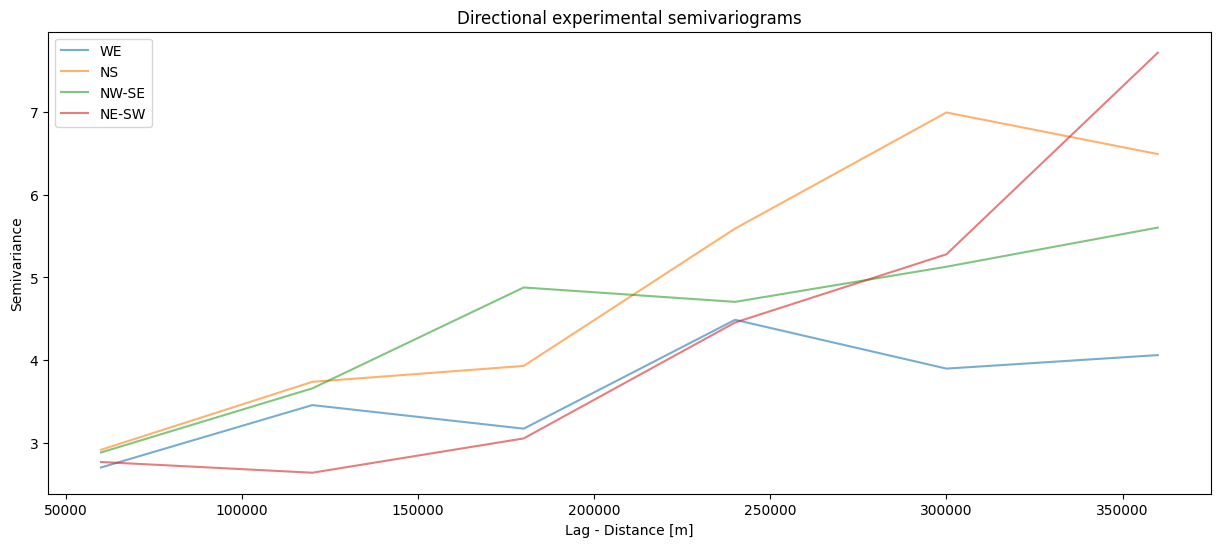

In [10]:
legends = []
plt.figure(figsize=(15, 6))
for idx, direction in enumerate(DIRECTIONS):
    semi = calculate_semivariance(
        ds=df[['geometry', VALUE_COL]],
        step_size=SEMI_MAJOR_AXIS_SIZE,
        max_range=MAX_RANGE,
        direction=direction,
        tolerance=TOLERANCE
    )
    plt.plot(semi[:, 0],
             semi[:, 1],
             alpha=0.6)
    legends.append(DIRECTIONS_ABBR[idx])
    
plt.title('Directional experimental semivariograms')
plt.xlabel('Lag - Distance [m]')
plt.ylabel('Semivariance')
plt.legend(legends)
plt.show()

##### Conclusion

Comparing **WE** and **NS** semivariograms:

- the **WE** variogram shows less variability in the function of distance,
- the **NS** variogram shows more variability in the function of distance,

and this is exactly what we should expect from the data analysis performed before!

Which one is better though?

- **WE**: implies more spatial homogeneity or smoothness in the data, and it can oversimplify predictions of a kriging model. It will smooth variability in a dataset.
- **NS**: signifies greater spatial heterogeneity or roughness in the data. Models based on this variogram could lead to better predictions in areas with high variability.

The best idea is to test different directions with the cross-validation technique. You will learn about it in the future chapters.



#### Directional covariograms

In analogy to directional semivariograms, you can estimate directional covariograms. The name of a function differs, but rest of the syntax is the same.

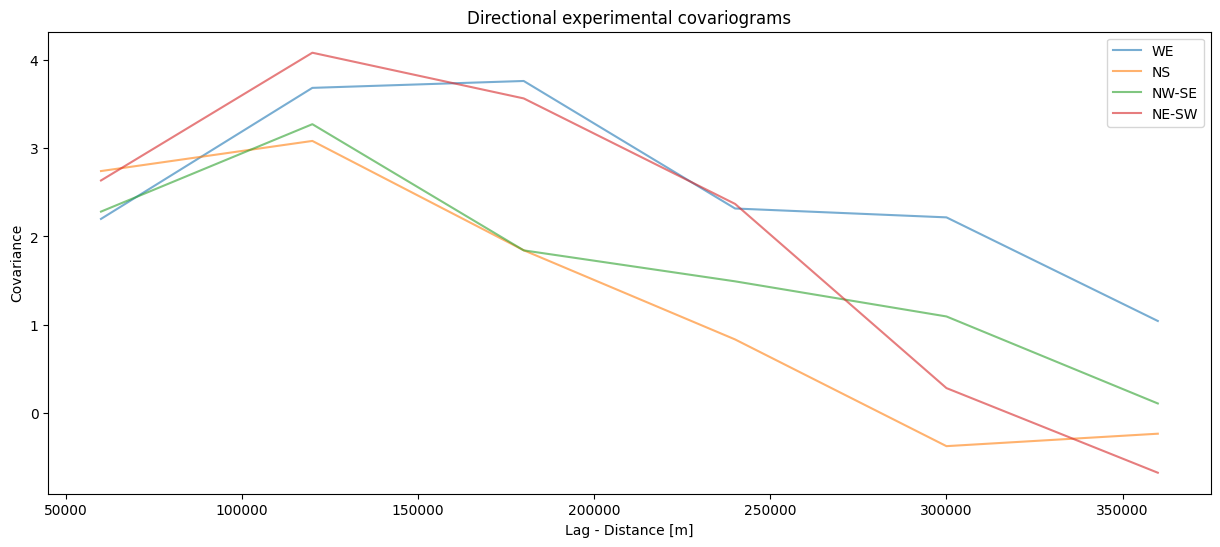

In [11]:
legends = []
plt.figure(figsize=(15, 6))
for idx, direction in enumerate(DIRECTIONS):
    semi = calculate_covariance(
        ds=df[['geometry', VALUE_COL]],
        step_size=SEMI_MAJOR_AXIS_SIZE,
        max_range=MAX_RANGE,
        direction=direction,
        tolerance=TOLERANCE
    )
    plt.plot(semi[:, 0],
             semi[:, 1],
             alpha=0.6)
    legends.append(DIRECTIONS_ABBR[idx])
    
plt.title('Directional experimental covariograms')
plt.xlabel('Lag - Distance [m]')
plt.ylabel('Covariance')
plt.legend(legends)
plt.show()

##### Conclusion

Comparing **WE** and **NS** covariograms:

- the **WE** covariance is higher for a distant lags - neighbors are more similar in this direction,
- the **NS** covariance is lower for a distant lags - neighbors are less similar in this direction,

Both directions lead to the same conclusions as for the semivariogram analysis.

